## Loading Packages

In [9]:
from Foresight import *
set_seed(42)

True

### Insuring that training is done on GPU if available

In [10]:
device = 'cpu'

if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
    
    if torch.cuda.device_count() > 1:
        print("Parallel Available")
        parallel=True
        
    else:
        parallel=False
        
else:
    print("No GPU available!")
    parallel=False

No GPU available!


## Loading Data

In [11]:
# Custom dataset if desired
# custom_list=["cu_lme", "al_lme"]

path = "../Data/"
universe_dict = universe_select(path, "Cu", custom_list=None)

## Setting run conditions

In [12]:
use_lg_returns = False
use_PCA = True
autoregressive = False
saving = False
loading = False
feat_spawn = False
forecast_length = 5

## Preprocessing

In [13]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)

# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)

# Making sure that all the points in the window have consistent length
universe_dict = truncate_window_length(universe_dict)

# Generating the dataset
if use_lg_returns:
    # Lg Returns Only
    df_full = generate_dataset(universe_dict, lg_only=True, price_only=False)
    target_col = "cu_lme"

else:
    # Price Only
    df_full = generate_dataset(universe_dict, lg_only=False, price_only=True)
    target_col = "price_cu_lme"
    
if autoregressive:
    df_full = df_full[[target_col]]
    
if feat_spawn:
    df_full = feature_spawn(df_full)

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci


### Visualise the dataset

In [26]:
df_full.head(5)
# df_full.tail(5)
# Visualise the plots if desired
# visualise_df(df_full)

,price_cu_shfe,price_cu_lme,price_cu_comex_p,price_cu_comex_s,price_peso,price_sol,price_bdi,price_ted,price_vix,price_skew,price_gsci
date,,,,,,,,,,,
2006-09-13,69540.0,7484.5,3.3925,15748.0,537.35,3.2530,4129.0,4.901,11.18,120.44,438.38855
2006-09-14,71350.0,7439.0,3.3820,14180.0,537.73,3.2475,4207.0,4.926,11.55,119.47,433.72522
2006-09-15,69400.0,7281.0,3.3165,14775.0,537.10,3.2480,4258.0,4.939,11.76,135.25,431.58291
2006-09-18,69830.0,7459.0,3.4180,15263.0,537.10,3.2450,4279.0,4.949,11.78,127.35,434.97293
2006-09-19,71470.0,7516.0,3.3755,17523.0,537.10,3.2450,4275.0,4.948,11.98,125.03,426.51240


### Normalizing the dataset

In [15]:
# Data scaling
scaler_data_X = MinMaxScaler()
scaler_data_y = MinMaxScaler()

df_target = df_full[[target_col]]

data_X = scaler_data_X.fit_transform(df_full)[:-forecast_length, :]
# Need to have an independent scaler for inverse_transforming later
data_y = scaler_data_y.fit_transform(df_target)

# Offset target one forecast length
data_y = data_y[forecast_length:, :]

print("Data X shape", data_X.shape,
      "\nData y shape", data_y.shape)

Data X shape (3348, 11) 
Data y shape (3348, 1)


### PCA

In [16]:
# Reducing the dataset to containing a threshold amount of variance
if use_PCA:
    n_dim = dimension_selector(data_X, thresh=0.95)
    data_X = dimension_reduce(data_X, n_dim)

Number of dimensions: 6
Explained Variance Sum: 0.965
Explained Variance Composition [0.49081574 0.23242886 0.14340036 0.04819284 0.02760431 0.02205961]


### Slicing Series into Windows

In [17]:
# The input size of each time series window
series_length = 132
data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=1.0)

# [Number of series, time series length, number of features]
print("Data X shape", data_X.shape,
      "\nData y shape", data_y.shape)

Data X shape (3216, 132, 6) 
Data y shape (3216, 1)


### Hyperparameters

In [19]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 32

# Training Parameters
n_epochs = 200
patience = 50
disp_freq= 10
fig_disp_freq= 10


# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 8
dense_hidden = 32
num_layers = 1
output_dim = 1
dropout = 0.0

### Initialising the model

In [20]:
model = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim,
             dense_hidden=dense_hidden,
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device,
             dropout=dropout)

if parallel:
    model = nn.DataParallel(model)
    print("Parallel Workflow\n")
    
model.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 6 
hidden_dim 8
series_length 132 
batch_size 32
output_dim 1 
num_layers 1
data_X  (3216, 132, 6) 
data_y (3216, 1)


### Training

In [23]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=n_epochs,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=disp_freq,
                        fig_disp_freq=fig_disp_freq, 
                        device=device,
                        patience=patience, 
                        scaler_data_X=scaler_data_X, 
                        scaler_data_y=scaler_data_y)

# Splitting the data into the train, validation and test sets
learning.train_val_test()

Epoch: 0 Train: 0.83450 Val: 0.32229  Time: 8.239  Best Val: 0.32229


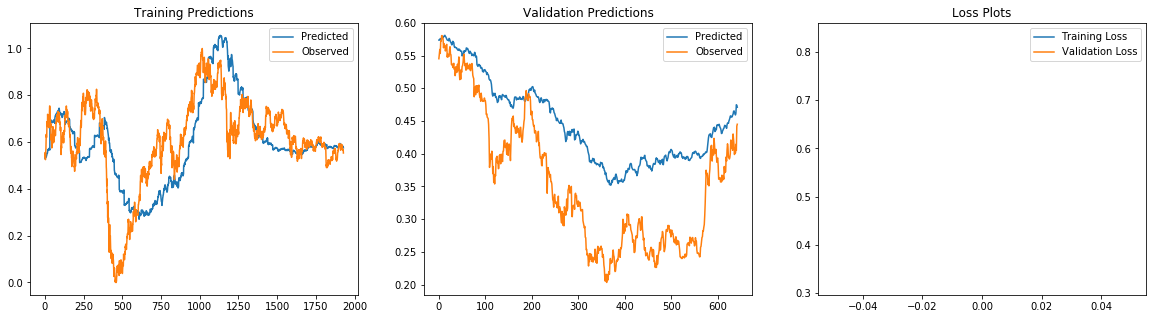

Epoch: 10 Train: 0.12784 Val: 0.10822  Time: 87.716  Best Val: 0.03129


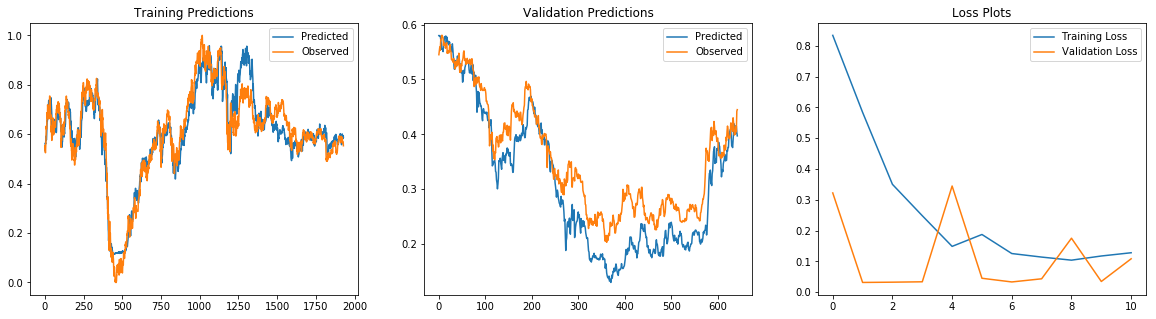

Epoch: 20 Train: 0.24842 Val: 0.04838  Time: 160.795  Best Val: 0.02569


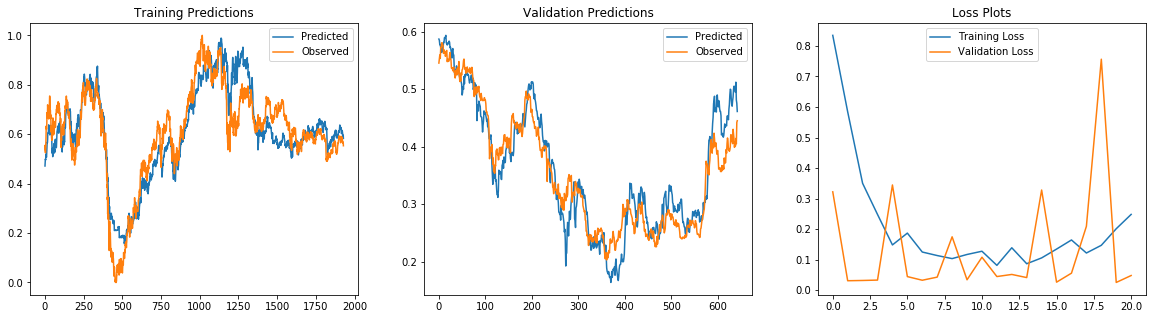

Epoch: 30 Train: 0.13013 Val: 0.06840  Time: 214.716  Best Val: 0.02569


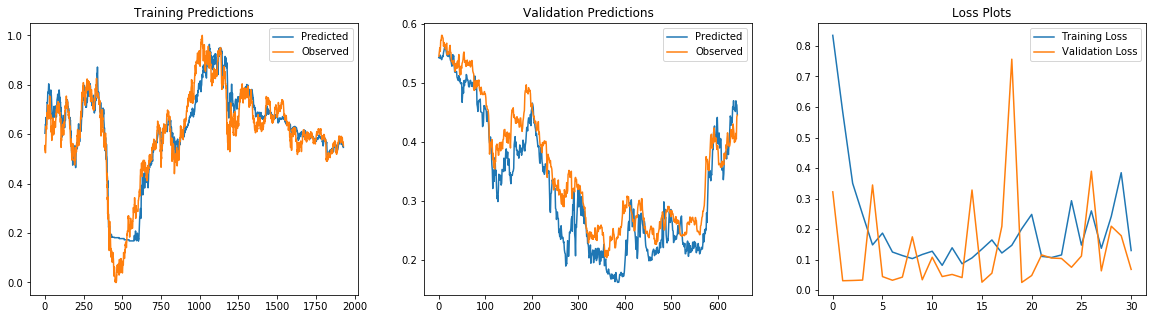

Epoch: 40 Train: 0.19726 Val: 0.14682  Time: 262.046  Best Val: 0.02569


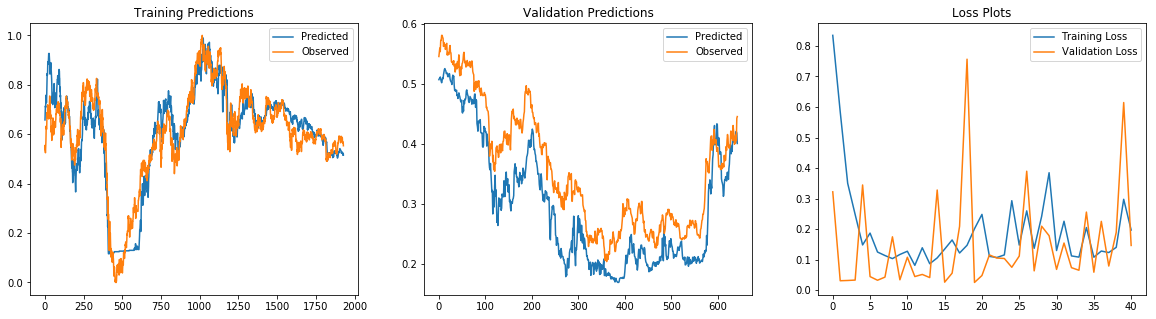

Epoch: 50 Train: 0.09216 Val: 0.07986  Time: 310.646  Best Val: 0.02569


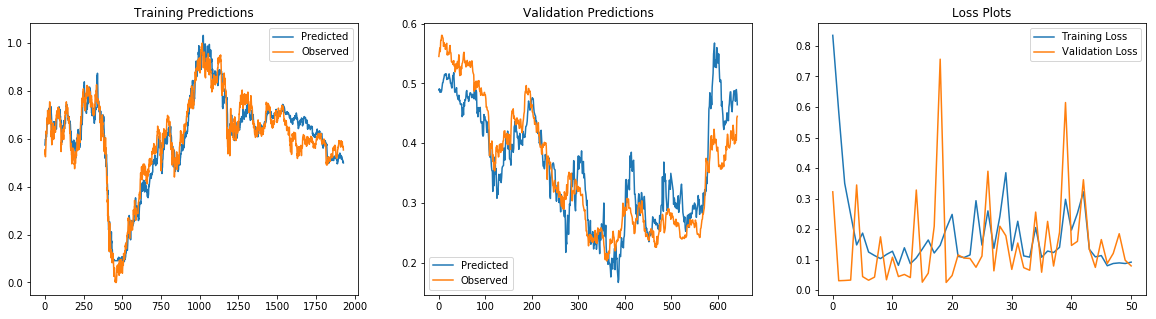

Epoch: 60 Train: 0.09984 Val: 0.16630  Time: 370.753  Best Val: 0.02569


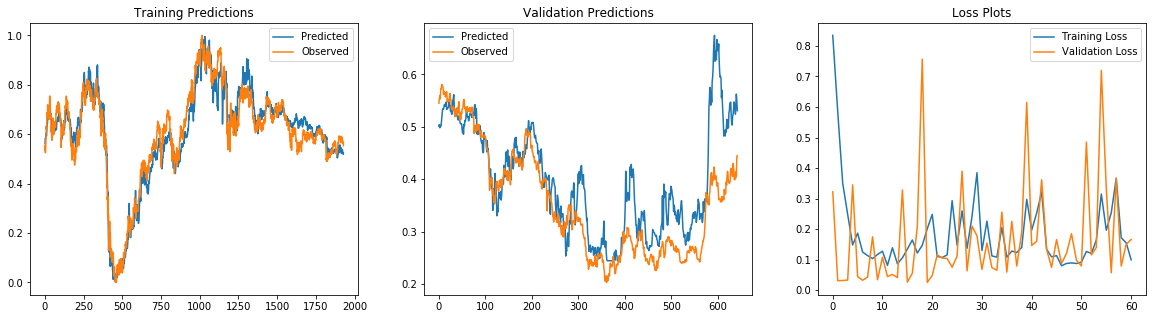

Early Stopping


In [24]:
# Allows for continious training by resetting the patience counter
# learning.n_epochs = 200
learning.early.stop = False
learning.early.counter = 0
learning.training_wrapper()

### Evaluating the Test Data

In [13]:
learning.evaluate(learning.best_model, learning.test_loader)

0.0897294012656123

### Saving Model Objects

In [14]:
model_name = "Multivariate" + "_F" + str(forecast_length) + "_W" + str(series_length) + "_Dense" + str(dense_hidden) 
print(model_name)

if saving:
    print("Saving")
    # Saving Pickle
    pickle.dump(learning, open("Results/Pickles/Multivariate/" + model_name, 'wb'))
    # Saving Model Pth
    model_save(model, model_name, path="../Results/Pths/Multivariate/")

Multivariate_F5_W132_Dense32


### Loading Model Objects

####  Must be running on GPU to load pickles that trained on GPU

In [15]:
if loading:
    # Loading Pickle
    if device != 'cpu':
        
        # Input Name of Model to load
        model_load = "" 
        
        # Load Pickle
        learning = pickle.load(open("Results/Pickles/Multivariate//" + model_load, 'rb'))

        # Loading Learning Object
        model = model_load(path="../Results/Pths/Multivariate/", model_name=model_load)

### Plotting

In [16]:
# Observed
train_true = learning.scaler_data_y.inverse_transform(learning.y_train.numpy())
val_true  = learning.scaler_data_y.inverse_transform(learning.y_val.numpy())
test_true  = learning.scaler_data_y.inverse_transform(learning.y_test.numpy())

# Predicted
train_pred = learning.scaler_data_y.inverse_transform(np.array(learning.train_predictions))
val_pred  = learning.scaler_data_y.inverse_transform(np.array(learning.val_predictions))
test_pred = learning.scaler_data_y.inverse_transform(np.array(learning.test_predictions))

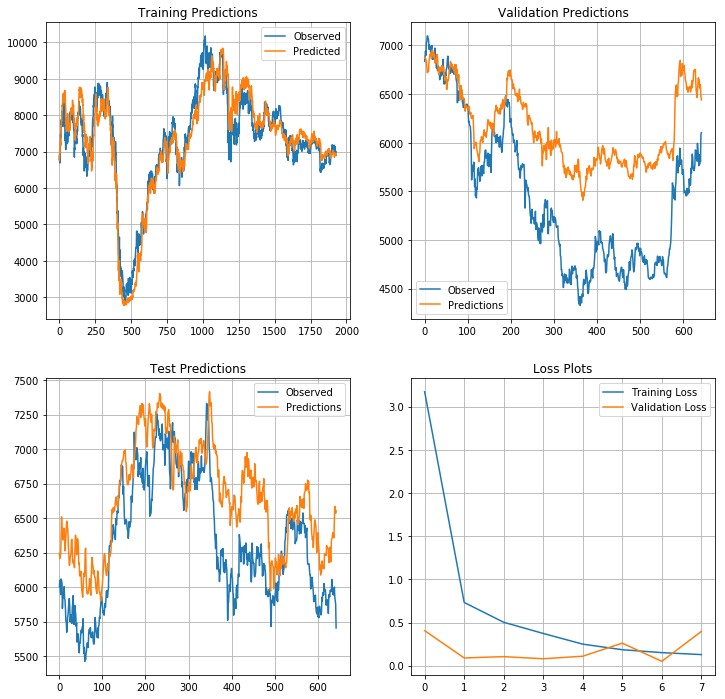

In [17]:
# Rescaling Example
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(train_true, label="Observed")
ax[0, 0].plot(train_pred, label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(val_true, label="Observed")
ax[0, 1].plot(val_pred, label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(test_true, label="Observed")
ax[1, 0].plot(test_pred, label="Predictions")
ax[1, 0].legend()

ax[1, 1].grid()
ax[1, 1].set_title("Loss Plots")
ax[1, 1].plot(learning.logs['Training Loss'], label="Training Loss")
ax[1, 1].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[1, 1].legend()

epoch_reached = str(len(learning.logs['Training Loss']))
path = "../Results/Plots/"
val_loss = learning.best_val_score

if saving:
    print("Saving")
    plt.savefig(path + model_name + ".png")

plt.show()

# Results

In [18]:
mse, mae, mda = evaluate(test_pred, test_true, log_ret=False)
print("Price Metrics: ", 
      mse, mae, mda)

Price Metrics:  153991.27514426573 332.7784718207966 0.4447900466562986


### Naive Benchmark

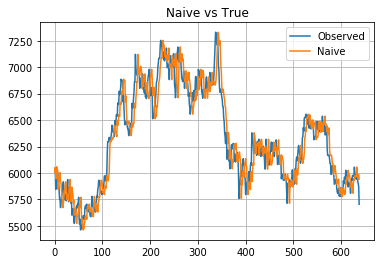

In [19]:
naive_pred = test_true[:-forecast_length]

plt.plot(test_true[forecast_length:] ,label="Observed")
plt.plot(naive_pred,label="Naive")
plt.title("Naive vs True")
plt.grid()
plt.legend()
if saving:
    plt.savefig("Results/Plots/" + "Naive_F" + str(forecast_length))
plt.show()

### Metrics for benchmarks

In [20]:
mse_naive, mae_naive, mda_naive = evaluate(naive_pred, test_true[forecast_length:], log_ret=False)
print("naive", mse_naive, mae_naive, mda_naive)

naive 21753.918 115.52818 0.47335423197492166


In [35]:
print("For Mean Squared Error:")

if mse_naive < mse:
    print("Naive Wins")
else:
    print("LSTM Wins")
    
print("For Mean Absolute Error:")

if mae_naive < mae:
    print("Naive Wins")
else:
    print("LSTM Wins")
    
print("For Mean Directional Accuracy:")

if mda_naive > mda:
    print("Naive Wins")
else:
    print("LSTM Wins")

For Mean Squared Error:
Naive Wins
For Mean Absolute Error:
Naive Wins
For Mean Directional Accuracy:
Naive Wins
